In [5]:
#Different libraries that we need 

import numpy as np # numerical python for operations on arrays, matrix
import pandas as pd # very efficient for handling databases 
import matplotlib.pyplot as plt # for plots 
import glob # for accessing directories (where the data are)
from scipy import stats # scientific python - for special functions and probability densities 
import re # for regular expressions 
from tqdm import tqdm_notebook as tqdm 

# in order to plot inline, Jupyter Notebook only 
%matplotlib inline

## Importing Data from .csv files

In [2]:
# Import all the .csv files 
trackFiles = []
trackFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track/*.csv')

shapeFiles = []
shapeFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Shapes/*.csv')

In [3]:
probeFiles = []

# Filtering probe trials 
# if probeFilter = True, probetrials are not used in the future statistics
# if probeFilter = False, probetrials are going to take part in the stats
probeFilter = True 

if probeFilter == True:
    regExpr = re.compile(r'p_Track')
    regExpr2 = re.compile(r'p_shape')
    
    probeFiles = list(filter(lambda i : regExpr.search(i), trackFiles))
    trackFiles = list(filter(lambda i : not regExpr.search(i), trackFiles))
    shapeFiles = list(filter(lambda i : not regExpr2.search(i), shapeFiles))
    
    
else : 
    trackFiles = trackFiles 
    shapeFiles = shapeFiles


In [6]:
# Creating list of tracking Data as list of pandas dataframes 
trackData = []
for i in tqdm(range(0,len(trackFiles))) : 
    trackData.append(pd.read_csv(trackFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    """_Track.csv files:
    Columns: T(s), X(m), Y(m), A(deg), R(Hz), D(m), V(m/s), S(m):
    T: camera frame time
    X: x coordinate of the head tip @ grid frame of reference
    Y: y coordinate of the head tip @ grid frame of reference
    A: head orientation
    R: EOD rate
    D: Distance per EOD pulse (=1/sampling_density)
    V: Head speed (m/s, signed)
    S: Distance per Escan (=1/escan_density)"""
    


#Adding landmark name and color in order to create a new dataframe for shapes

landm_name = {'Shape': ['Triangle Lg', 'Triangle Sm',  'Square Lg', 'Square Sm', 'Circle Lg', 'Circle Sm', 'Food']} 
shape_names = pd.DataFrame(data = landm_name)

color_shapes = pd.DataFrame(data = np.linspace(0,1,7), columns= ['Color'])

shapeData = []
for i in tqdm(range(0,len(shapeFiles))) : 
    shapeData.append(pd.read_csv(shapeFiles[i], names = ["X", "Y", "Angle"]))
    shapeData[i] = pd.concat([shape_names,shapeData[i]], axis = 1)
    shapeData[i] = pd.concat([shapeData[i], color_shapes], axis = 1)
    
    """_shapes.csv files:
    Columns: X(m), Y(m), A(deg):
    X(m): x coordinate of the shape center @ grid frame of reference
    Y(m): y coordinate of the shape center @ grid frame of reference
    A(deg): Shape orientation
    Rows: "Triangle Lg", "Triangle Sm", "Square Lg", "Square Sm", "Circle Lg", "Circle Sm", "Food", """

# Creating list of probe Data as list of pandas dataframes 
probeData = []
for i in tqdm(range(0,len(probeFiles))) : 
    probeData.append(pd.read_csv(probeFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    


In [7]:
#Quick consistency check 
len(trackData) == len(shapeData)

True

In [8]:
len(probeData)

14

# Initial Heading Distributions

## Initial Heading Angle Distribution -- Late learning Trials

In [31]:
# Extracting every first row from each trackData dataframe using iloc 
# ref  : (https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/#iloc-selection)
# Why from 23 ? previous runs were part of early-learning trials 
IHADistrib = pd.concat([trackData[i].iloc[[0]].drop(columns = ['Time']) for i in range(23, len(trackData))]) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000007663861550>]],
      dtype=object)

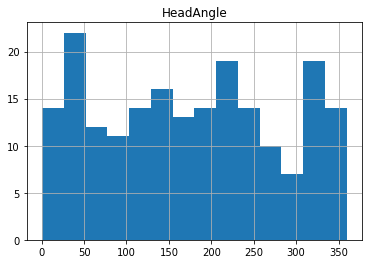

In [18]:
IHADistrib.hist(column = 'HeadAngle', bins = 14)

## Initial Heading Magnitude Distribution - Late Learning Trials

In [19]:
# Getting initial position vectors 
initialPositionVector = []

for i in range(0,len(positionVector)):
    initialPositionVector.append(positionVector[i].drop(positionVector[i].index[[0,1]]))

# Distribution of initial position as pandas dataframe (very efficient)
IPVDistribution = pd.concat(initialPositionVector[i].iloc[[0]].drop(columns = ['HeadAngle','Time']) for i in range(141,len(trackData)))

NameError: name 'positionVector' is not defined

In [20]:
# Plotting the distribution as a histogram 
IPVDistribution.hist(column = 'Magnitude', bins = 8, density = True)

# Gaussian Distribution Fitting 
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(IPVDistribution['Magnitude']))

m, s = stats.norm.fit(IPVDistribution['Magnitude']) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it

NameError: name 'IPVDistribution' is not defined

# Plotting Trajectories 
### Plotting an Example trajectory (it can be done for every trajectory)

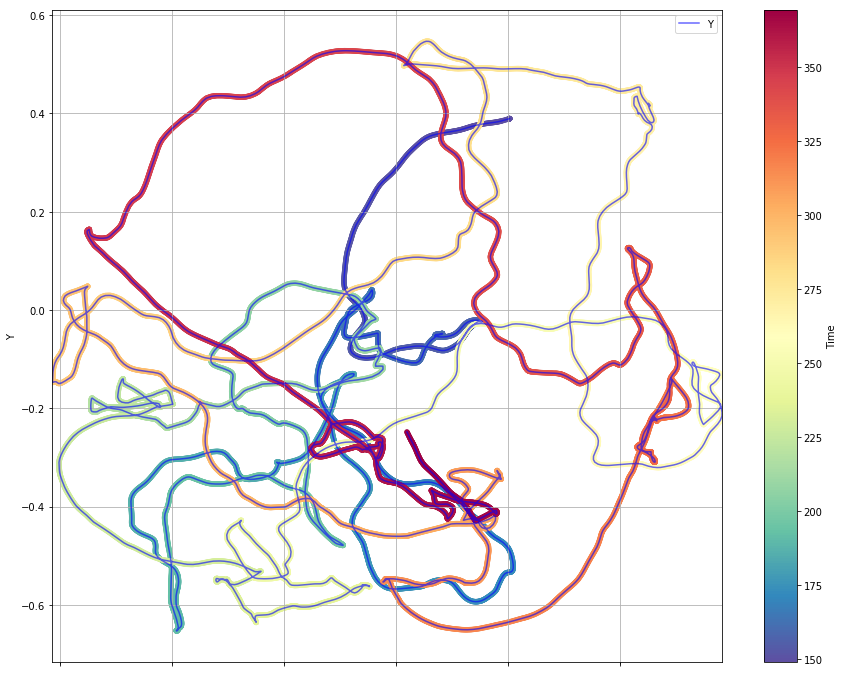

In [21]:
# Plotting each trajectory with Spectral colormap based on time --> as James did in matlab 
# The colormap is related to time --> take a look on the side of the plot 
ax = trackData[1].plot.scatter(x = "X", y = 'Y',c = 'Time', cmap = 'Spectral_r', 
                             figsize= (15,12))
# Adding polygonal chain in order to see the trajectory and get vector length later 
trackData[1].plot.line(x = "X", y = 'Y', ax = ax, style = 'b', alpha = 0.6 ,grid = True)

# Vector magnitude and angle

## Position Vector (time dependent) -- Whole Dataset



In [22]:
# Getting the difference between coordinates (x,y) in order to get the magnitude
# List of Dataframes
difference = []

for i in range(0,len(trackData)):
    pivotVar = trackData[i].diff().drop(columns = ['HeadAngle'])
    difference.append(pivotVar.drop(pivotVar.index[0]))
    
# Getting magnitude as norm (np.linalg.norm)
magnitude = []
for i in tqdm(range(0,len(difference))):
    magnitude.append(difference[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
    magnitude[i].columns = ['Magnitude']

In [23]:
# Getting angle 
angle = []
for i in tqdm(range(0,len(trackData))):
    pivotVar = trackData[i].drop(columns = ['Time','X', 'Y'] )
    angle.append(pivotVar.drop(pivotVar.index[0]))

In [24]:
# Getting Time
time = []
for i in tqdm(range(0,len(difference))):
    time.append(difference[i].drop(columns = ['X', 'Y']))

In [25]:
# Getting final dataframe --> vector features
positionVector = []
pivotDataframe = []

for i in tqdm(range(0,len(magnitude))):
    pivotDataframe.append(pd.merge(magnitude[i], angle[i], left_index= True, right_index = True))
    positionVector.append(pd.merge(pivotDataframe[i], time[i], left_index= True, right_index = True))
    

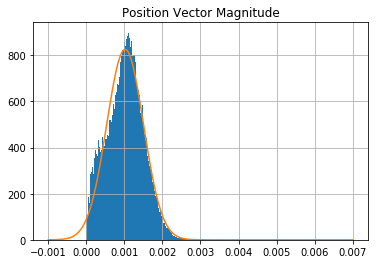

In [26]:
# VectorMagnitude Distribution
# Take a look at the Learning Curve to set range(latetrials) for now 13-21 sessions
PMDistribution = pd.concat([positionVector[i] for i in range(23, len(trackData))]) 

# Magnitude Distribution
PMDistribution.hist(column= 'Magnitude', bins = 360, density = True)
plt.title('Position Vector Magnitude')

# Gaussian Distribution Fitting 
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(PMDistribution['Magnitude']))

m, s = stats.norm.fit(PMDistribution['Magnitude']) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it


(0, 6000)

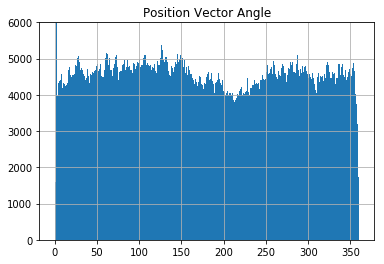

In [30]:
# Angle Distribution

PMDistribution.hist(column= 'HeadAngle', bins = 300)
plt.title('Position Vector Angle')
plt.ylim(0,6000)

## Velocity vector -- Whole dataset

In [259]:
# Getting difference between two subsequent positions --> differential geometry velocity
posDifference = []

for i in range(0,len(positionVector)):
    pivotVar = positionVector[i].diff().drop(columns = ['HA', 'Time'])
    posDifference.append(pivotVar.drop(pivotVar.index[0]))

In [260]:
# Time difference between two subsequent positions 
timeDifference = []
for i in range(0,len(time)):
    timeDifference.append(time[i].drop(time[i].index[0]))

In [261]:
# Setting velocity vector
velocityVector = [] 
for i in range(0,len(posDifference)):
    pivotVar = pd.merge(posDifference[i], timeDifference[i], left_index= True, right_index = True)
    velocityVector.append(pivotVar.rename(columns = {'Magnitude' : 'PosDifference'}))
    

# Getting velocity as differential geometry definition
# Getting magnitude 

velocity = []
for i in range(0,len(velocityVector)):
    pivotVar = velocityVector[i]['PosDifference']/velocityVector[i]['Time']
    velocity.append(pivotVar.apply(lambda x : np.linalg.norm(x)).to_frame())
    velocity[i].columns = ['Velocity']
    
for i in range(0,len(velocityVector)):
# Final velocity Dataframe 
    velocityVector[i] = pd.merge(velocityVector[i], velocity[i], left_index= True, right_index = True)


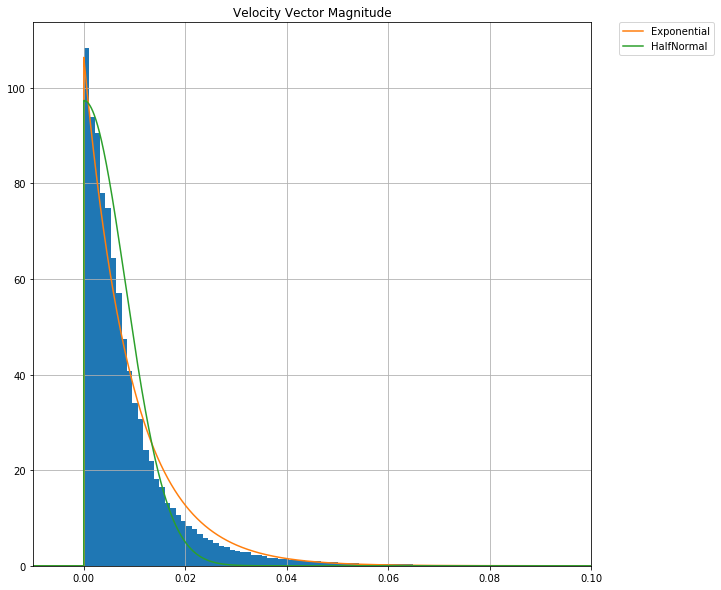

In [262]:
# Velocity Magnitude Distribution 
VMDistribution = pd.concat([velocityVector[i] for i in range(23, len(trackData))])
# Handle exceptions
VMDistribution = VMDistribution.fillna(value = 0 )
VMDistribution = VMDistribution.replace(np.inf, 0)
VMDistribution = VMDistribution.replace(-np.inf, 0)

#Histogram
VMDistribution.hist(column= 'Velocity', bins = 600, density = True, figsize=(10,10))
plt.title('Velocity Vector Magnitude')
plt.xlim(-0.01,0.10)


# Gaussian Distribution Fitting / Exponential Distribution Fitting 
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(VMDistribution['Velocity']))

loc, scale = stats.expon.fit(VMDistribution['Velocity']) # get mean and standard deviation  
pdf_expon = stats.expon.pdf(lnspc
                            ,loc , scale) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_expon, label="Exponential") # plot it

lochn, scalehn = stats.halfnorm.fit(VMDistribution['Velocity']) # get mean and standard deviation  
pdf_hnorm = stats.halfnorm.pdf(lnspc
                            ,lochn , 0.0082) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_hnorm, label="HalfNormal") # plot it

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [18]:
for i in range(0,1):
    print("trackData[" + str(i) +"].to_csv('C:\\Users\jamesjun\Desktop\TrackFiles\CsvFinal\Shuffle\\trackData"+str(i)+"', encoding='utf-8', index=False)")

trackData[0].to_csv('C:\Users\jamesjun\Desktop\TrackFiles\CsvFinal\Shuffle\trackData0', encoding='utf-8', index=False)


# Bar Plots 

In [32]:
posDifferenceProbe = []
for i in range(0,len(probeData)):
    pivotVar = probeData[i].diff().drop(columns = ['HeadAngle', 'Time'])
    posDifferenceProbe.append(pivotVar.drop(pivotVar.index[0]))

distanceProbe = []
for i in range(0,len(posDifferenceProbe)):
    distanceProbe.append(posDifferenceProbe[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
    distanceProbe[i].columns = ['distanceProbe']

distanceTotProbe = []
for i in range(0,len(distanceProbe)):
    distanceTotProbe.append(distanceProbe[i].sum())
    distanceTotProbe[i] = distanceTotProbe[i][0]

distanceTotProbe = np.asarray(distanceTotProbe)



posDifferenceEarly = []
for i in range(0,6):
    pivotVar = trackData[i].diff().drop(columns = ['HeadAngle', 'Time'])
    posDifferenceEarly.append(pivotVar.drop(pivotVar.index[0]))

distanceEarly = []
for i in range(0,len(posDifferenceEarly)):
    distanceEarly.append(posDifferenceEarly[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
    distanceEarly[i].columns = ['distanceEarly']

distanceTotEarly = []
for i in range(0,len(distanceEarly)):
    distanceTotEarly.append(distanceEarly[i].sum())
    distanceTotEarly[i] = distanceTotEarly[i][0]

distanceTotEarly = np.asarray(distanceTotEarly)



posDifferenceLate = []
for i in range(50,len(trackData)):
    pivotVar = trackData[i].diff().drop(columns = ['HeadAngle', 'Time'])
    posDifferenceLate.append(pivotVar.drop(pivotVar.index[0]))

distanceLate = []
for i in range(0,len(posDifferenceLate)):
    distanceLate.append(posDifferenceLate[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
    distanceLate[i].columns = ['distanceLate']

distanceTotLate = []
for i in range(0,len(distanceLate)):
    distanceTotLate.append(distanceLate[i].sum())
    distanceTotLate[i] = distanceTotLate[i][0]

distanceTotLate = np.asarray(distanceTotLate)


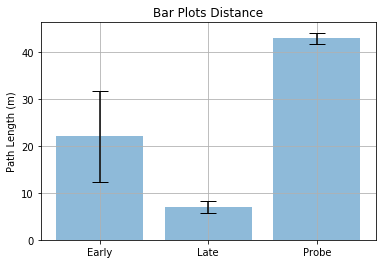

In [33]:
objects = ('Early', 'Late', 'Probe')
y_pos = np.arange(len(objects))
distance = [distanceTotEarly.mean(), distanceTotLate.mean(), distanceTotProbe.mean()]
distance_std = [distanceTotEarly.std()/(np.sqrt(len(distanceTotEarly))), distanceTotLate.std()/(np.sqrt(len(distanceTotLate))),
                distanceTotProbe.std()/(np.sqrt(len(distanceTotProbe)))]

plt.figure(0)
plt.bar(y_pos, distance, yerr = distance_std,align = 'center', alpha = 0.5, capsize = 8 )
plt.grid()
plt.xticks(y_pos, objects)
plt.ylabel('Path Length (m)')
plt.title('Bar Plots Distance')
plt.savefig('DistanceBars.jpg')


In [34]:
## Time Bar Plots 

durationEarly = []

for i in range(0,6):
    durationEarly.append(trackData[i].iloc[-1]['Time'] - trackData[i].iloc[0]['Time'])
    
    

durationEarly = np.asarray(durationEarly)

durationLate = []

for i in range(50,len(trackData)):
    durationLate.append(trackData[i].iloc[-1]['Time'] - trackData[i].iloc[0]['Time'])

durationLate = np.asarray(durationLate)

durationProbe = []

for i in range(0,len(probeData)):
    durationProbe.append(probeData[i].iloc[-1]['Time'] - probeData[i].iloc[0]['Time'])
    
durationProbe = np.asarray(durationProbe)

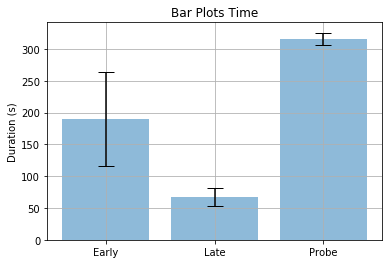

In [35]:
objects1 = ('Early', 'Late', 'Probe')
y_pos1 = np.arange(len(objects1))
duration = [durationEarly.mean(), durationLate.mean(), durationProbe.mean()]
duration_std = [durationEarly.std()/(np.sqrt(len(durationEarly))), durationLate.std()/(np.sqrt(len(durationLate))),
                durationProbe.std()/(np.sqrt(len(durationProbe)))]

plt.figure(1)
plt.bar(y_pos1, duration, yerr = duration_std,align = 'center', alpha = 0.5, capsize = 8 )
plt.xticks(y_pos1, objects1)
plt.grid()
plt.ylabel('Duration (s)')
plt.title('Bar Plots Time')
plt.savefig('DurationBars.jpg')

# Learning Curves 

In [38]:
#Distance vs session # and Duration vs Session # 


(149,)

In [44]:
trackFiles

['C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C02A2_Track.csv',
 'C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C02A3_Track.csv',
 'C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C02B1_Track.csv',
 'C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C02C1_Track.csv',
 'C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C02C2_Track.csv',
 'C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C02C3_Track.csv',
 'C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C02C4_Track.csv',
 'C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C03A1_Track.csv',
 'C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C03A2_Track.csv',
 'C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C03A3_Track.csv',
 'C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C03A4_Track.csv',
 'C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C03B1_Track.csv',
 'C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C03B2_Track.csv',
 'C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track\\C03B3_Track.csv',
 'C:/U